In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

import os
import multiprocessing as mp
from tqdm import tqdm
# import time

# For Perceptron
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder


### Data Preprocessing

In [2]:
with open("./train.txt") as f:
    train_file_list = f.readlines()
with open("./val.txt") as f:
    val_file_list = f.readlines()
with open("./test.txt") as f:
    test_file_list = f.readlines()

train_file_list = [x.strip().split(sep=" ") for x in train_file_list]
val_file_list = [x.strip().split(sep=" ") for x in val_file_list]
test_file_list = [x.strip().split(sep=" ") for x in test_file_list]

train_label = [int(x[1]) for x in train_file_list]
val_label = [int(x[1]) for x in val_file_list]
test_label = [int(x[1]) for x in test_file_list]

train_file_list = [x[0] for x in train_file_list]
val_file_list = [x[0] for x in val_file_list]
test_file_list = [x[0] for x in test_file_list]

# print("# cpus: ", os.cpu_count())
NUM_PROCESSES = 8

def ReadImage(filePath):
    image = cv2.imread(filePath, cv2.IMREAD_COLOR)
    # image = cv2.imread(filePath, cv2.IMREAD_GRAYSCALE)
    # image = cv2.resize(image, (256, 256))
    return image

with mp.Pool(processes=NUM_PROCESSES) as pool:
    train_imgs = pool.map(ReadImage, tqdm(train_file_list))
    val_imgs = pool.map(ReadImage, tqdm(val_file_list))
    test_imgs = pool.map(ReadImage, tqdm(test_file_list))

# resize the images to 256x256
def ResizeImage(image):
    # resized_img = cv2.resize(image, (256, 256))
    resized_img = cv2.resize(image, (64, 64))
    return resized_img

with mp.Pool(processes=NUM_PROCESSES) as pool:
    resized_train_imgs = pool.map(ResizeImage, tqdm(train_imgs))
    resized_val_imgs = pool.map(ResizeImage, tqdm(val_imgs))
    resized_test_imgs = pool.map(ResizeImage, tqdm(test_imgs))


# Ref.: https://github.com/Ixiaohuihuihui/Extract-color-histogram-feature/blob/master/rgb_feature.py
# extract rgb features
def ExtractColorHistFeatures(image):
    features = []
    for channel in range(3):
        hist = cv2.calcHist(images=[image], channels=[channel], mask=None, histSize=[64], ranges=[0,256])
        hist = cv2.normalize(hist, hist)
        # features.extend(hist)
        features.append(hist)
    return features

with mp.Pool(processes=NUM_PROCESSES) as pool:
    ### tqdm returns an iterator
    # train_features = pool.map(ExtractFeatures, tqdm(resized_train_imgs))
    # val_features = pool.map(ExtractFeatures, tqdm(resized_val_imgs))
    # test_features = pool.map(ExtractFeatures, tqdm(resized_test_imgs))
    train_features = list(tqdm(pool.imap(ExtractColorHistFeatures, resized_train_imgs), total=len(resized_train_imgs)))
    val_features = list(tqdm(pool.imap(ExtractColorHistFeatures, resized_val_imgs), total=len(resized_val_imgs)))
    test_features = list(tqdm(pool.imap(ExtractColorHistFeatures, resized_test_imgs), total=len(resized_test_imgs)))


# flatten and reshape the features into (n_samples, n_features)
train_features = np.array(train_features)
val_features = np.array(val_features)
test_features = np.array(test_features)

def FlattenFeatures(feature):
    return feature.flatten()

with mp.Pool(processes=NUM_PROCESSES) as pool:
    train_features = np.array(pool.map(FlattenFeatures, tqdm(train_features)))
    val_features = np.array(pool.map(FlattenFeatures, tqdm(val_features)))
    test_features = np.array(pool.map(FlattenFeatures, tqdm(test_features)))

# # flatten and reshape the features into (n_samples, n_features)
# resized_train_imgs = np.array(resized_train_imgs)
# resized_val_imgs = np.array(resized_val_imgs)
# resized_test_imgs = np.array(resized_test_imgs)

# def FlattenImages(image):
#     return image.flatten()

# with mp.Pool(processes=NUM_PROCESSES) as pool:
#     resized_train_imgs = np.array(pool.map(FlattenImages, tqdm(resized_train_imgs)))
#     resized_val_imgs = np.array(pool.map(FlattenImages, tqdm(resized_val_imgs)))
#     resized_test_imgs = np.array(pool.map(FlattenImages, tqdm(resized_test_imgs)))

100%|██████████| 450/450 [00:00<00:00, 41985.96it/s]


In [3]:
def onehot(label, n_classes):
    enc = np.zeros(shape=(len(label), n_classes))
    for idx, val in enumerate(label):
        enc[idx, val] = 1
    return enc

train_label = onehot(np.array(train_label), 50)
val_label = onehot(np.array(val_label), 50)
test_label = onehot(np.array(test_label), 50)

In [4]:
# # normalize the input of perceptron
# normalized_resized_train_imgs = resized_train_imgs / 255
# normalized_resized_val_imgs = resized_val_imgs / 255
# normalized_resized_test_imgs = resized_test_imgs / 255

In [5]:
class DataLoader:
    def __init__(self, data, labels, batch_size=32, shuffle=True):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_samples = data.shape[0]
        self.num_batches = int(np.ceil(self.num_samples / self.batch_size))
        self.indices = np.arange(self.num_samples)
        self.current_batch = 0
        
        if self.shuffle:
            np.random.shuffle(self.indices)
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.current_batch >= self.num_batches:
            self.current_batch = 0
            if self.shuffle:
                np.random.shuffle(self.indices)
            raise StopIteration
            
        batch_indices = self.indices[self.current_batch*self.batch_size : (self.current_batch+1)*self.batch_size]
        batch_data = self.data[batch_indices]
        batch_labels = self.labels[batch_indices]
        
        self.current_batch += 1
        
        return batch_data, batch_labels
    


train_dataloader = DataLoader(train_features, train_label, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_features, val_label, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_features, test_label, batch_size=32, shuffle=True)

### Two Layer Perceptron

In [5]:
# Implement by computational graph
class Node:
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []
        for n in self.inputs:
            n.outputs.append(self)
        self.value = None

    def forward(self):
        raise NotImplemented

    def backward(self):
        raise NotImplemented

class Input(Node):
    def __init__(self, name=''):
        Node.__init__(self, inputs=[])
        self.name = name

    def forward(self, value=None):
        if value is not None:
            self.value = value

    def backward(self):
        pass

class Add(Node):
    def __init__(self, x, y):
        Node.__init__(self, inputs=[x, y])

    def forward(self):
        self.value = sum([n.value for n in self.inputs])

    def backward(self):
        for n in self.inputs:
            if n not in self.outputs:
                n.value += self.value

class Multiply(Node):
    def __init__(self, x, y):
        Node.__init__(self, inputs=[x, y])

    def forward(self):
        self.value = np.dot(self.inputs[0].value, self.inputs[1].value)

    def backward(self):
        for n in self.inputs:
            if n not in self.outputs:
                n.value += self.value * n.inputs[np.abs(self.inputs.index(n)-1)].value

class Sigmoid(Node):
    def __init__(self, x):
        Node.__init__(self, inputs=[x])

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self):
        self.value = self.sigmoid(self.inputs[0].value)

    def backward(self):
        for n in self.inputs:
            if n not in self.outputs:
                n.value += self.value * (1 - self.value) * self.outputs[0].value

class TwoLayerPerceptron:
    def __init__(self, n_inputs, n_hidden, n_outputs, learning_rate=0.1):
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.n_outputs = n_outputs
        self.learning_rate = learning_rate
        # Initialize weights and biases with random values
        self.W1 = np.random.randn(n_inputs, n_hidden)
        self.b1 = np.random.randn(n_hidden)
        self.W2 = np.random.randn(n_hidden, n_outputs)
        self.b2 = np.random.randn(n_outputs)

        # Create input and output nodes
        self.inputs = [Input(name='input') for i in range(n_inputs)]
        self.hidden_inputs = [Input(name=f'hidden_input_{i}') for i in range(n_hidden)]
        self.outputs = [Input(name='output') for i in range(n_outputs)]

        # Create nodes for each operation in the forward pass
        self.weights1_node = Multiply(self.inputs[0], Input(value=self.W1))
        self.bias1_node = Add(self.weights1_node, Input(value=self.b1))
        self.hidden_activations_node = Sigmoid(self.bias1_node)
        self.weights2_node = Multiply(self.hidden_activations_node, Input(value=self.W2))
        self.bias2_node = Add(self.weights2_node, Input(value=self.b2))
        self.output_node = Sigmoid(self.bias2_node)

    def forward(self, X):
        # Set input values
        for i in range(self.n_inputs):
            self.inputs[i].forward(X[:,i])
        # Compute activations of hidden layer
        self.weights1_node.forward()
        self.bias1_node.forward()
        self.hidden_activations_node.forward()
        # Compute activations of output layer
        self.weights2_node.forward()
        self.bias2_node.forward()
        self.output_node.forward()
        # Return output node value
        return self.output_node.value
    
    def backward(self, y):
        # Compute error at output layer
        output_error_node = Add(self.outputs[0], Input(value=-y))
        output_delta_node = Multiply(output_error_node, Sigmoid(self.outputs[0], deriv=True))
        # Compute error at hidden layer
        hidden_error_node = Multiply(output_delta_node, Input(value=self.W2.T))
        hidden_delta_node = Multiply(hidden_error_node, Sigmoid(self.hidden_activations_node, deriv=True))
        # Update weights and biases
        dW2_node = Multiply(self.hidden_activations_node, output_delta_node)
        self.W2 -= self.learning_rate * dW2_node.inputs[1].value
        db2_node = output_delta_node
        self.b2 -= self.learning_rate * db2_node.value
        dW1_node = Multiply(self.inputs[0], hidden_delta_node)
        self.W1 -= self.learning_rate * dW1_node.inputs[1].value
        db1_node = hidden_delta_node
        self.b1 -= self.learning_rate * db1_node.value
        # Backward pass
        dhidden_node = Add(self.weights1_node, db1_node)
        dinput_node = Multiply(self.inputs[0], dhidden_node)
        # Return gradients
        return dinput_node.value
    
    def train(self, X, y, n_epochs=1000):
        for i in range(n_epochs):
            # Forward pass
            y_hat = self.forward(X)
            # Compute and print loss every 100 epochs
            if i % 100 == 0:
                loss = np.mean(np.square(y - y_hat))
                print(f"Epoch {i}, Loss: {loss:.4f}")
            # Backward pass
            self.outputs[0].forward(y_hat)
            dinput = self.backward(y)


In [8]:
# Generate toy dataset
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([[0], [1], [1], [0]])

# Create and train a two-layered perceptron
mlp = TwoLayerPerceptron(n_inputs=2, n_hidden=3, n_outputs=1, learning_rate=0.1)
mlp.train(X, y, n_epochs=1000)

# Evaluate the trained perceptron on the input data
y_pred = mlp.forward(X)
print("Predictions:", y_pred.round(2))

TypeError: __init__() got an unexpected keyword argument 'value'

In [54]:
class TwoLayerPerceptron:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        np.random.seed(42)
        self.limit = 1 / math.sqrt(input_size)
        # self.weights1 = np.random.randn(self.input_size, self.hidden_size)
        self.weights1 = np.random.uniform(low=-self.limit, high=self.limit, size=(self.input_size, self.hidden_size))
        self.biases1 = np.zeros((1, self.hidden_size))
        # self.weights2 = np.random.randn(self.hidden_size, self.output_size)
        self.weights2 = np.random.uniform(low=-self.limit, high=self.limit, size=(self.hidden_size, self.output_size))
        self.biases2 = np.zeros((1, self.output_size))
        
    def forward(self, X):
        # Layer 1
        self.z1 = np.dot(X, self.weights1) + self.biases1
        # self.a1 = np.exp(self.z1) / np.sum(np.exp(self.z1), axis=1, keepdims=True)  # Softmax
        self.a1 = 1 / (1 + np.exp(-self.z1))  # Sigmoid
        # self.a1 = np.maximum(np.zeros(self.z1.shape), self.z1)  # ReLU
        
        # Layer 2
        self.z2 = np.dot(self.a1, self.weights2) + self.biases2
        self.a2 = np.exp(self.z2) / np.sum(np.exp(self.z2), axis=1, keepdims=True)
        
        return self.a2
    
    def backward(self, X, y, learning_rate):
        # Compute error
        delta3 = self.a2 - y
        delta2 = np.dot(delta3, self.weights2.T) * (self.a1 * (1 - self.a1))
        
        # Compute gradients
        d_weights2 = np.dot(self.a1.T, delta3)
        d_biases2 = np.sum(delta3, axis=0, keepdims=True)
        d_weights1 = np.dot(X.T, delta2)
        d_biases1 = np.sum(delta2, axis=0)
        
        # Update weights and biases
        self.weights2 -= learning_rate * d_weights2
        self.biases2 -= learning_rate * d_biases2
        self.weights1 -= learning_rate * d_weights1
        self.biases1 -= learning_rate * d_biases1
        
    def train(self, train_dataloader, val_dataloader, learning_rate, epochs):
        train_losses = []
        val_losses = []
        train_accuracy = []
        val_accuracy = []
        for epoch in range(epochs):
            # Train
            loss_epoch, acc_epoch = 0, 0
            for X, y in train_dataloader:
                # Forward pass
                output = self.forward(X)
                
                # Compute loss
                loss = np.mean(-np.sum(y * np.log(output), axis=1))
                
                # Compute accuracy
                acc = np.mean(np.argmax(output, axis=1) == np.argmax(y, axis=1))

                # Backward pass
                self.backward(X, y, learning_rate)

                loss_epoch += loss
                acc_epoch += acc
            
            loss_epoch /= train_dataloader.num_batches
            acc_epoch /= train_dataloader.num_batches
            train_losses.append(loss_epoch)
            train_accuracy.append(acc_epoch)
            
            # # Print progress
            # if epoch % 100 == 0:
            #     print(f"Epoch {epoch + 1}, Train Loss {loss_epoch:.4f}")
    
            # Validation
            loss_epoch, acc_epoch = 0, 0
            for X, y in val_dataloader:
                # Forward pass
                output = self.forward(X)

                # Compute loss
                loss = np.mean(-np.sum(y * np.log(output), axis=1))

                # Compute accuracy
                acc = np.mean(np.argmax(output, axis=1) == np.argmax(y, axis=1))

                loss_epoch += loss
                acc_epoch += acc
            
            loss_epoch /= val_dataloader.num_batches
            acc_epoch /= val_dataloader.num_batches
            val_losses.append(loss_epoch)
            val_accuracy.append(acc_epoch)

            # Print progress
            if epoch % 100 == 0:
                print(f"Epoch: {epoch+1}, Train Loss: {train_losses[epoch]:.4f}, Val Loss: {val_losses[epoch]:.4f}")

        return train_losses, val_losses, train_accuracy, val_accuracy


    def predict(self, X):
        # Forward pass
        output = self.forward(X)
        
        # Return predicted class
        return np.argmax(output, axis=1)


### Training & Evaluation

In [55]:
perceptron = TwoLayerPerceptron(input_size=train_features.shape[1],
                                hidden_size=32,
                                output_size=50)

# Train model
train_losses, val_losses, train_accuracy, val_accuracy = perceptron.train(train_dataloader=train_dataloader,
                                                                          val_dataloader=val_dataloader,
                                                                          learning_rate=1e-3,
                                                                          epochs=25000)

Epoch: 1, Train Loss: 1.8979, Val Loss: 3.9097
Epoch: 101, Train Loss: 3.5908, Val Loss: 3.6005
Epoch: 201, Train Loss: 3.5329, Val Loss: 3.5664
Epoch: 301, Train Loss: 3.4950, Val Loss: 3.5045
Epoch: 401, Train Loss: 3.4662, Val Loss: 3.4879
Epoch: 501, Train Loss: 3.4456, Val Loss: 3.5300
Epoch: 601, Train Loss: 3.4309, Val Loss: 3.4747
Epoch: 701, Train Loss: 3.4194, Val Loss: 3.4678
Epoch: 801, Train Loss: 3.4099, Val Loss: 3.4813
Epoch: 901, Train Loss: 3.4023, Val Loss: 3.4496
Epoch: 1001, Train Loss: 3.3957, Val Loss: 3.3766
Epoch: 1101, Train Loss: 3.3897, Val Loss: 3.4122
Epoch: 1201, Train Loss: 3.3842, Val Loss: 3.4370
Epoch: 1301, Train Loss: 3.3795, Val Loss: 3.5215
Epoch: 1401, Train Loss: 3.3754, Val Loss: 3.4093
Epoch: 1501, Train Loss: 3.3713, Val Loss: 3.4669
Epoch: 1601, Train Loss: 3.3683, Val Loss: 3.3688
Epoch: 1701, Train Loss: 3.3651, Val Loss: 3.3878
Epoch: 1801, Train Loss: 3.3626, Val Loss: 3.3885
Epoch: 1901, Train Loss: 3.3598, Val Loss: 3.4360
Epoch: 2001,

In [1]:
# Evaluate model
y_pred = perceptron.predict(test_features)
accuracy = np.mean(y_pred == np.argmax(test_label, axis=1))
print(f"Accuracy: {accuracy:.4f}")

NameError: name 'perceptron' is not defined

In [ ]:
EPOCHS = 25000

def draw_losses(train_losses=None, val_losses=None, test_losses=None):
    if train_losses!=None:
        plt.plot(np.arange(EPOCHS), train_losses, label='Training Loss')
    if val_losses!=None:
        plt.plot(np.arange(EPOCHS), val_losses, label='Validation Loss')
    if test_losses!=None:    
        plt.plot(np.arange(EPOCHS), test_losses, label='Test Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def draw_accuracy(train_acc=None, val_acc=None, test_acc=None):
    if train_acc!=None:
        plt.plot(np.arange(EPOCHS), train_acc, label='Training Accuracy')
    if val_acc!=None:
        plt.plot(np.arange(EPOCHS), val_acc, label='Validation Accuracy')
    if test_acc!=None:    
        plt.plot(np.arange(EPOCHS), test_acc, label='Test Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

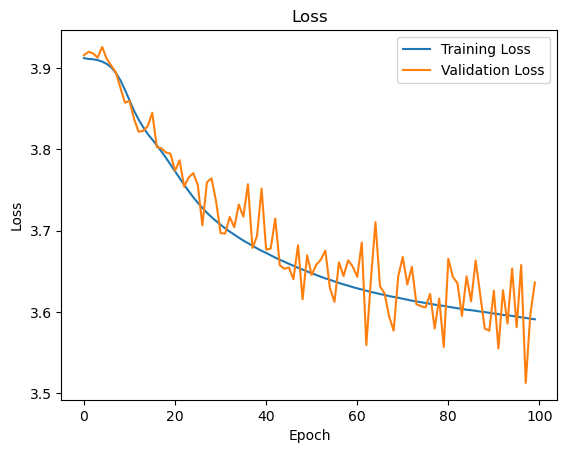

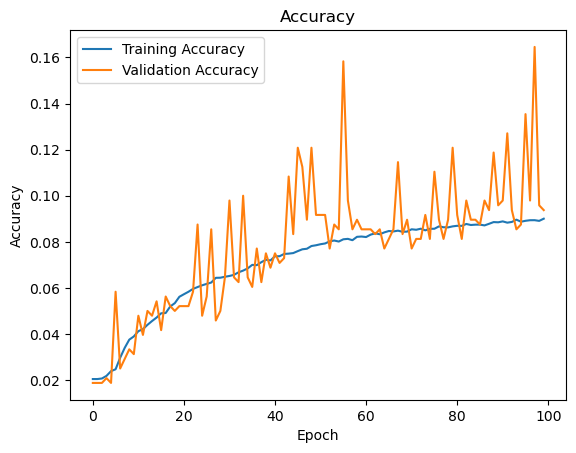

In [ ]:
draw_losses(train_losses=train_losses, val_losses=val_losses)
draw_accuracy(train_acc=train_accuracy, val_acc=val_accuracy)